# Python Practice Lecture 22 MATH 342W Queens College 
# - Using Probability Estimation to do Classification
## Author: Amir ElTabakh
## Date: April 26, 2022

## Agenda:
* Review of using Probability Estimation
* Asymmetric Cost Classifiers
* Receiver-Operator Curve (ROC) Plot
* Detection Error Tradeoff (DET) curve
* Using AUC to Compare Probabilistic Classification Models
* Choosing a Decision Threshold Based on Asymmetric Costs and Rewards

## Review of using Probability Estimation

We're going to pick up where we left off in the previous demo (21).

1. Load in the adult data set
2. Process the data appropriately
3. Train-test split
4. Fit a logistic model with the hyperparameter $p = 0.5$

In [1]:
# importing dependencies
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay

# Data viz
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette(sns.color_palette("colorblind")) # setting color palette
sns.set(rc={"figure.figsize":(10, 10)}) #width=10, #height=6

In [2]:
# URL for adult Data
url = "https://raw.githubusercontent.com/sfnxboy/342-2022-Python-Practice-lectures/main/Datasets/ucidata_adult.csv"
adult = pd.read_csv(url, error_bad_lines=False)

# snapshot of dataframe
adult

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32555,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32556,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32557,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32558,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [3]:
# dropping rows that contain a missing value
adult = adult.dropna()

# reset index
adult = adult.reset_index()

# dummifying categorical variables
adult = pd.get_dummies(adult)

# snapshot
adult

,index,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,...,native_country_Scotland,native_country_South,native_country_Taiwan,native_country_Thailand,native_country_Trinadad&Tobago,native_country_United-States,native_country_Vietnam,native_country_Yugoslavia,income_<=50K,income_>50K
0,0,50,83311,13,0,0,13,0,0,0,...,0,0,0,0,0,1,0,0,1,0
1,1,38,215646,9,0,0,40,0,0,1,...,0,0,0,0,0,1,0,0,1,0
2,2,53,234721,7,0,0,40,0,0,1,...,0,0,0,0,0,1,0,0,1,0
3,3,28,338409,13,0,0,40,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,4,37,284582,14,0,0,40,0,0,1,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30156,32555,27,257302,12,0,0,38,0,0,1,...,0,0,0,0,0,1,0,0,1,0
30157,32556,40,154374,9,0,0,40,0,0,1,...,0,0,0,0,0,1,0,0,0,1
30158,32557,58,151910,9,0,0,40,0,0,1,...,0,0,0,0,0,1,0,0,1,0
30159,32558,22,201490,9,0,0,20,0,0,1,...,0,0,0,0,0,1,0,0,1,0


In [4]:
# train test split
# defining X and y
X = adult.iloc[:, :-1]
y = adult.iloc[:, -1]

# adding 1 vector to X
X.insert(0, "one_vec", 1)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.25,
                                                    random_state = 2020)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(22620, 107)
(7541, 107)
(22620,)
(7541,)


In [5]:
# Fitting logistic regression model
model = LogisticRegression(random_state=0, solver = 'saga').fit(X_train, y_train)

# Get probabilities
p_hats_train = model.predict_proba(X_train)[:, 1]
p_hats_test = model.predict_proba(X_test)[:, 1]

E:\Users\amira\anaconda\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Let's establish a rule: if the probability estimate is greater than or equal to 50%, let's classify the observation as positive, otherwise 0.

In [6]:
# defining y hats train
y_hats_train = [1 if p_hats_train[i] >= 0.5 else 0 for i in range(len(p_hats_train))]

How did this "classifier" do in-sample?

In [7]:
# missclassification error
np.mean(y_train != y_hats_train)

0.2107427055702918

Let's see the same thing oos:

In [8]:
# defining y hats test
y_hats_test = [1 if p_hats_test[i] >= 0.5 else 0 for i in range(len(p_hats_test))]

# missclassification error
np.mean(y_test != y_hats_test)

0.21482561994430446

A tad bit worse. Let's look at the OOS confusion matrix.

[[5578   85]
 [1535  343]]


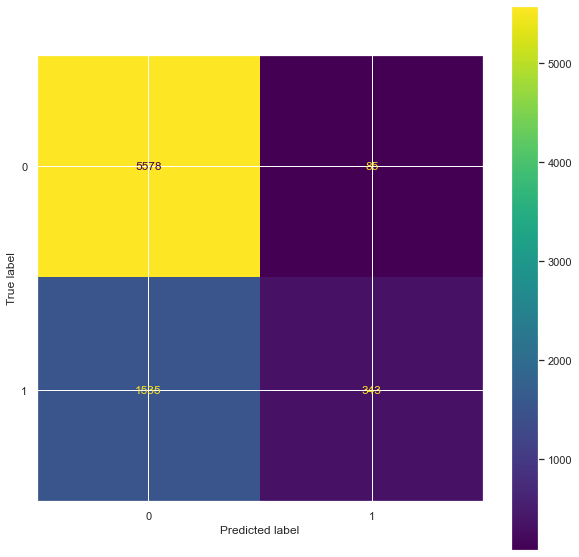

In [9]:
# in sample confusion matrix
from sklearn import metrics
c_matrix_oos = metrics.confusion_matrix(y_test, y_hats_test)

print(c_matrix_oos)

# confusion plot
ConfusionMatrixDisplay.from_predictions(y_test, y_hats_test)

Here are estimates OOS of the future performance for each class:

In [10]:
tn, fp, fn, tp = c_matrix_oos.ravel()

print(f"True Postives: {tp}")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")

num_pred_pos = np.sum(c_matrix_oos[:, 1])
num_pred_neg = np.sum(c_matrix_oos[:, 0])
num_true_pos = np.sum(c_matrix_oos[1, :])
num_true_neg = np.sum(c_matrix_oos[0, :])

print(f"Predicted Positives: {num_pred_pos}")
print(f"Predicted Negatives: {num_pred_neg}")
print(f"Actual Positives: {num_true_pos}")
print(f"Actual Negatives: {num_true_neg}")

# precision
precision = tp / num_pred_pos
print(f"Precision: {round(precision, 5)}")

# recall
recall = tp / num_true_pos
print(f"Recall: {round(recall, 5)}")

# false discovery rate
false_discovery_rate = 1 - precision
print(f"FDR: {round(false_discovery_rate, 5)}")

# false ommision rate
false_ommision_rate = fn / num_pred_neg
print(f"FOR: {round(false_ommision_rate, 5)}")

True Postives: 343
True Negatives: 5578
False Positives: 85
False Negatives: 1535
Predicted Positives: 428
Predicted Negatives: 7113
Actual Positives: 1878
Actual Negatives: 5663
Precision: 0.8014
Recall: 0.18264
FDR: 0.1986
FOR: 0.2158


This whole classifier hinged on the decision of 50%! What if we change it? This is called asymmetric cost classification.

## Asymmetric Cost Classifiers

Let's establish a *new* rule: if the probability estimate is greater than or equal to 90%, let's classify the observation as positive, otherwise 0.

We've done this in the previous demo (21) so we're going to go through this quickly.

In [11]:
# defining y hats test
y_hats_test = [1 if p_hats_test[i] >= 0.9 else 0 for i in range(len(p_hats_test))]

np.mean(y_test != y_hats_test)

0.23166688768067895

Of course the misclassification error went up! But now look at the confusion table! The second column represents all $\hat{y} = 1$ and there's not too many of them! Why? You've made it *much* harder to classify something as positive.

[[   0 5663]
 [   0 1878]]


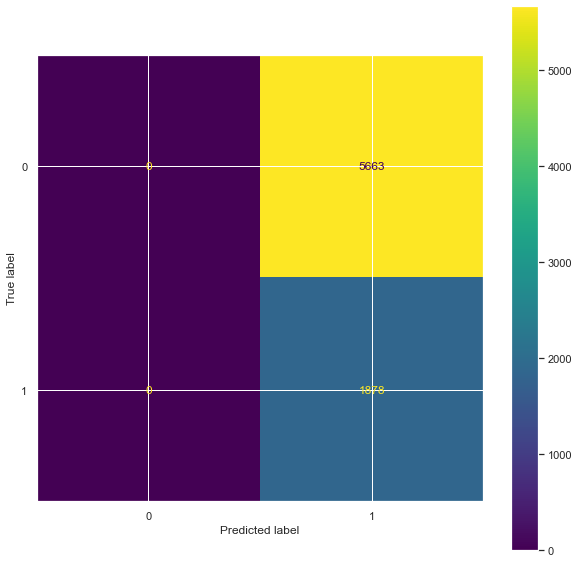

In [12]:
# confusion matrix
y_hats_test = [1 if p_hats_test[i] >= 0.001 else 0 for i in range(len(p_hats_test))]


c_matrix_oos = metrics.confusion_matrix(y_test, y_hats_test)
print(c_matrix_oos)

# confusion plot
ConfusionMatrixDisplay.from_predictions(y_test, y_hats_test)

In [13]:
c_matrix_oos[1, :]

array([   0, 1878], dtype=int64)

Here's the new additional performance metrics now:

In [14]:
# Performance metrics
tn, fp, fn, tp = c_matrix_oos.ravel()

print(f"True Postives: {tp}")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")

num_pred_pos = np.sum(c_matrix_oos[:, 1])
num_pred_neg = np.sum(c_matrix_oos[:, 0])
num_true_pos = np.sum(c_matrix_oos[1, :])
num_true_neg = np.sum(c_matrix_oos[0, :])

print(f"Predicted Positives: {num_pred_pos}")
print(f"Predicted Negatives: {num_pred_neg}")
print(f"Actual Positives: {num_true_pos}")
print(f"Actual Negatives: {num_true_neg}")

# precision
precision = tp / num_pred_pos
print(f"Precision: {round(precision, 5)}")

# recall
recall = tp / num_true_pos
print(f"Recall: {round(recall, 5)}")

# false discovery rate
false_discovery_rate = 1 - precision
print(f"FDR: {round(false_discovery_rate, 5)}")

# false ommision rate
false_ommision_rate = fn / num_pred_neg
print(f"FOR: {round(false_ommision_rate, 5)}")

True Postives: 1878
True Negatives: 0
False Positives: 5663
False Negatives: 0
Predicted Positives: 7541
Predicted Negatives: 0
Actual Positives: 1878
Actual Negatives: 5663
Precision: 0.24904
Recall: 1.0
FDR: 0.75096
FOR: nan


<ipython-input-14-a53458d8b644>:32: RuntimeWarning: invalid value encountered in longlong_scalars
  false_ommision_rate = fn / num_pred_neg


We don't make many false discoveries but we make a lot of false omissions! It's a tradeoff.

## Receiver-Operator Curve Plot

The entire classifier is indexed by that indicator function probability threshold which creates the classification decision. Why not see look at the entire range of possible classification models. We do this with a function. We will go through it slowly and explain each piece:

In [15]:
def compute_metrics_prob_classifier(p_hats, y_true, res = 0.001):
    """
    Computes performance metrics for a binary probabilistic classifer
    
    Each row of the result will represent one of the many models and its
    elements record the performance of that model so we can (1) pick a
    "best" model at the end and (2) overall understand the performance of
    the probability estimates a la the Brier scores, etc.
    
    Parameters
    ----------
    p_hats  :  The probability estimates for n predictions
    y_true  :  The true observed responses
    res     :  The resolution to use for the grid of threshold values (defaults to 1e-3)

    Return
    ------
    return  :  A dataframe of all performance results
    """
    p_thresholds = np.arange(0 + res, 1, res)
    
    # creating empty pandas dataframe
    col_names = ["p_th",
    "TN",
    "FP",
    "FN",
    "TP",
    "miscl_err",
    "precision",
    "recall",
    "FDR",
    "FPR",
    "FOR",
    "miss_rate"]
    
    performance_df = pd.DataFrame(columns=col_names)
    
    #now we iterate through each p_th and calculate all metrics about the classifier and save
    n = len(y_true)
    for i in range(len(p_thresholds)):
        p_th = p_thresholds[i]
        y_hats = [1 if p_hats[i] >= p_th else 0 for i in range(len(p_hats))]
        confusion_matrix = metrics.confusion_matrix(y_true, y_hats)
        
        # getting performance metrics
        tn, fp, fn, tp = confusion_matrix.ravel()
        
        num_pred_pos = np.sum(confusion_matrix[:, 1])
        num_pred_neg = np.sum(confusion_matrix[:, 0])
        num_true_pos = np.sum(confusion_matrix[1, :])
        num_true_neg = np.sum(confusion_matrix[0, :])
        
        # avoid division by 0 error
        if num_pred_neg != 0:
            false_ommision_rate = fn / num_pred_neg
        else:
            false_ommision_rate = 0
            
        # avoid division by 0 error
        if num_pred_pos != 0:
            precision = tp / num_pred_pos
        else:
            precision = 0
        
        missclassification_error = (fp + fn) / n
        recall = tp / num_true_pos
        false_discovery_rate = 1 - precision
        false_positive_rate = fp / num_true_neg
        miss_rate = fn / num_true_pos
        
        # populate data frame
        i_th_row = pd.Series({"p_th" : p_th,
                                "TN" : tn,
                                "FP" : fp,
                                "FN" : fn,
                                "TP" : tp,
                                "miscl_err" : missclassification_error,
                                "precision" : precision,
                                "recall" : recall,
                                "FDR" : false_discovery_rate,
                                "FPR" : false_positive_rate,
                                "FOR" : false_ommision_rate,
                                "miss_rate" : miss_rate
                            })
        
        performance_df = performance_df.append(i_th_row, ignore_index = True)
        
    return performance_df

Now let's generate performance results for the in-sample data. This might take a few seconds to run.

In [16]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.25,
                                                    random_state = 255)

# Fitting logistic regression model
model = LogisticRegression(random_state=0, solver = 'saga').fit(X_train, y_train)

p_hats_train = model.predict_proba(X_train)[:, 1]

E:\Users\amira\anaconda\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [17]:
performance_metrics_in_sample = compute_metrics_prob_classifier(p_hats_train, y_train)

# snapshot
performance_metrics_in_sample

,p_th,TN,FP,FN,TP,miscl_err,precision,recall,FDR,FPR,FOR,miss_rate
0,0.001,0.0,17052.0,0.0,5568.0,0.753846,0.246154,1.000000,0.753846,1.000000,0.000000,0.000000
1,0.002,0.0,17052.0,0.0,5568.0,0.753846,0.246154,1.000000,0.753846,1.000000,0.000000,0.000000
2,0.003,0.0,17052.0,0.0,5568.0,0.753846,0.246154,1.000000,0.753846,1.000000,0.000000,0.000000
3,0.004,2.0,17050.0,0.0,5568.0,0.753758,0.246176,1.000000,0.753824,0.999883,0.000000,0.000000
4,0.005,3.0,17049.0,0.0,5568.0,0.753714,0.246186,1.000000,0.753814,0.999824,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
994,0.995,17049.0,3.0,5439.0,129.0,0.240584,0.977273,0.023168,0.022727,0.000176,0.241862,0.976832
995,0.996,17049.0,3.0,5443.0,125.0,0.240760,0.976562,0.022450,0.023438,0.000176,0.241997,0.977550
996,0.997,17049.0,3.0,5451.0,117.0,0.241114,0.975000,0.021013,0.025000,0.000176,0.242267,0.978987
997,0.998,17049.0,3.0,5459.0,109.0,0.241468,0.973214,0.019576,0.026786,0.000176,0.242536,0.980424


Now let's plot the ROC curve.

In [18]:
# Shockingly there is no plt function to plot via slope and intercept.
# We create our own

def abline(slope, intercept, color = 'red'):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--', c = color)

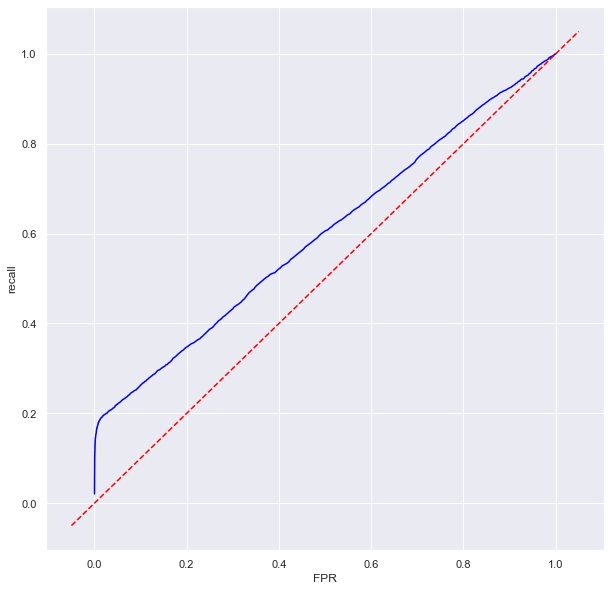

In [19]:
# Plotting ROC curve
FPR_vec_is = performance_metrics_in_sample['FPR']
recall_vec_is = performance_metrics_in_sample['recall']

sns.lineplot(x=FPR_vec_is,
             y=recall_vec_is,
             color = "blue")

abline(1, 0)

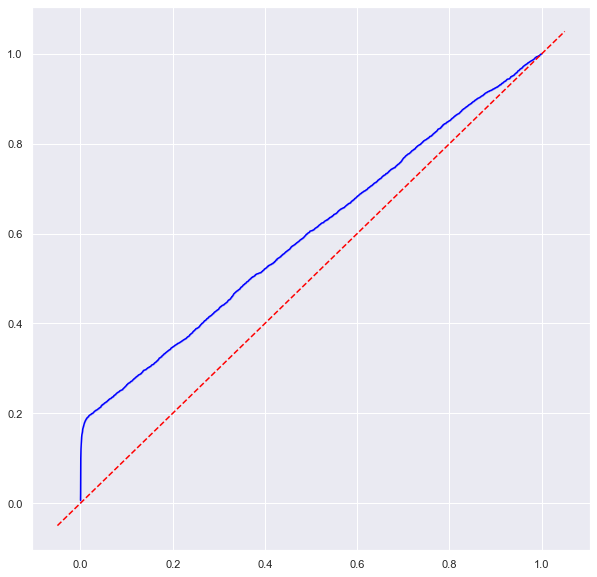

In [20]:
# We can repeat the process with sklearn
fpr, tpr, thresholds = metrics.roc_curve(y_train, p_hats_train, pos_label=1)

# Plotting ROC curve
sns.lineplot(x=fpr,
             y=tpr,
             color = "blue")

abline(1, 0)

Now calculate the area under the curve (AUC) which is used to evaluate the probabilistic classifier (just like the Brier score) using a trapezoid area function. 

In [21]:
# use numpy.trapz to integrate along the x-axis
np.absolute(np.trapz(x = FPR_vec_is, y = recall_vec_is))

0.5980741738084454

That AUC metric is nothing to write home about.

How did we do out of sample?

In [22]:
performance_metrics_oos = compute_metrics_prob_classifier(p_hats_test, y_test)

# snapshot
performance_metrics_oos

,p_th,TN,FP,FN,TP,miscl_err,precision,recall,FDR,FPR,FOR,miss_rate
0,0.001,0.0,5601.0,0.0,1940.0,0.742740,0.257260,1.000000,0.742740,1.000000,0.000000,0.000000
1,0.002,0.0,5601.0,0.0,1940.0,0.742740,0.257260,1.000000,0.742740,1.000000,0.000000,0.000000
2,0.003,0.0,5601.0,0.0,1940.0,0.742740,0.257260,1.000000,0.742740,1.000000,0.000000,0.000000
3,0.004,0.0,5601.0,0.0,1940.0,0.742740,0.257260,1.000000,0.742740,1.000000,0.000000,0.000000
4,0.005,0.0,5601.0,0.0,1940.0,0.742740,0.257260,1.000000,0.742740,1.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
994,0.995,5568.0,33.0,1929.0,11.0,0.260178,0.250000,0.005670,0.750000,0.005892,0.257303,0.994330
995,0.996,5569.0,32.0,1931.0,9.0,0.260310,0.219512,0.004639,0.780488,0.005713,0.257467,0.995361
996,0.997,5571.0,30.0,1931.0,9.0,0.260045,0.230769,0.004639,0.769231,0.005356,0.257398,0.995361
997,0.998,5573.0,28.0,1931.0,9.0,0.259780,0.243243,0.004639,0.756757,0.004999,0.257329,0.995361


And graph the OOS ROC:

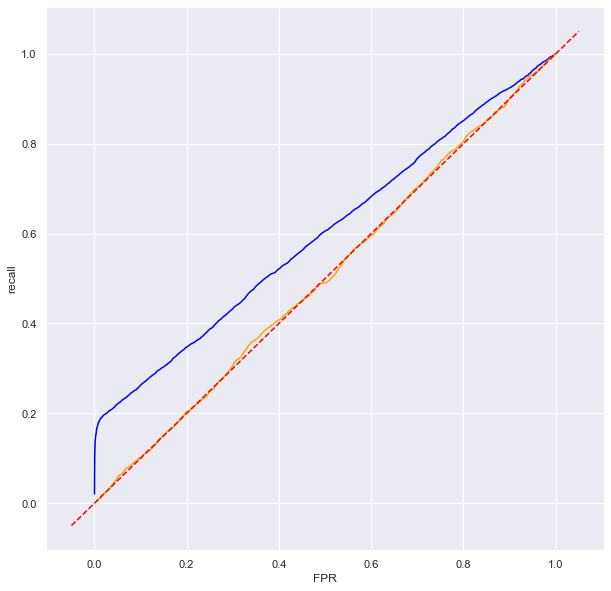

In [23]:
# Plotting ROC curve
FPR_vec_oos = performance_metrics_oos['FPR']
recall_vec_oos = performance_metrics_oos['recall']

# plot in sample ROC
sns.lineplot(x=FPR_vec_is,
             y=recall_vec_is,
             color = "blue")

# plot OOS ROC
sns.lineplot(x=FPR_vec_oos,
             y=recall_vec_oos,
             color = "orange")

# slope 1, intercept 0
abline(1, 0)

In [24]:
# calculate OOS AUC metric
np.absolute(np.trapz(x = FPR_vec_oos, y = recall_vec_oos))

0.5020406425951184

Only a tad worse! In the real world it's usually a lot worse. We are lucky we have a great number of samples in both the train and test set.

## Detection Error Tradeoff curve

<AxesSubplot:xlabel='FDR', ylabel='miss_rate'>

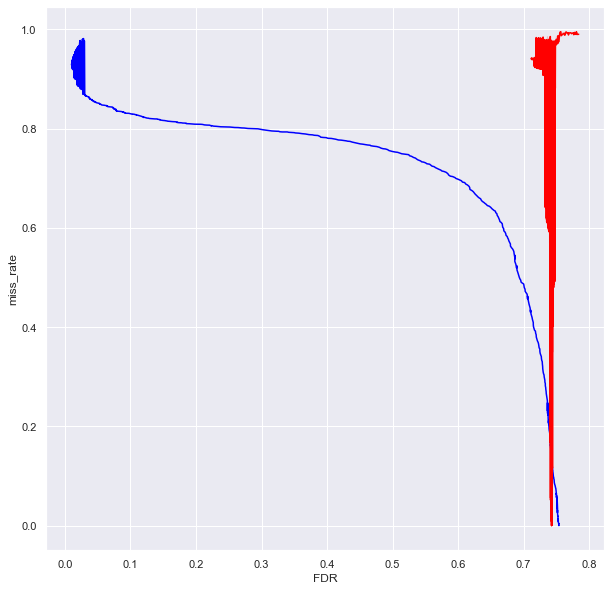

In [25]:
# Plotting DET curve
FDR_vec_is = performance_metrics_in_sample['FDR']
miss_rate_vec_is = performance_metrics_in_sample['miss_rate']

FDR_vec_oos = performance_metrics_oos['FDR']
miss_rate_vec_oos = performance_metrics_oos['miss_rate']

# plot in sample DET
sns.lineplot(x=FDR_vec_is,
             y=miss_rate_vec_is,
             color = "blue")

# plot OOS DET
sns.lineplot(x=FDR_vec_oos,
             y=miss_rate_vec_oos,
             color = "red")

## Using AUC to Compare Probabilistic Classification Models

What would the effect be of less information on the same traing set size? Imagine we didn't know the features: occupation, education, education_num, relationship, marital_status. How would we do relative to the above? Worse!

In [26]:
# URL for adult Data
url = "https://raw.githubusercontent.com/sfnxboy/342-2022-Python-Practice-lectures/main/Datasets/ucidata_adult.csv"
adult = pd.read_csv(url, error_bad_lines=False)

# delete columns
adult = adult.drop(['occupation', 'education', 'education_num',
                    'relationship', 'marital_status', 'fnlwgt'], axis=1)

# dropping rows that contain a missing value
adult = adult.dropna()

# reset index
#adult = adult.reset_index()

# dummifying categorical variables
adult = pd.get_dummies(adult)

# defining X and y
X = adult.iloc[:, :-1]
y = adult.iloc[:, -1]

# adding 1 vector to X
X.insert(0, "one_vec", 1)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.5,
                                                    random_state = 2020)

# fitting logistic regression model
model_reduced = LogisticRegression(random_state=0, solver = 'saga').fit(X_train, y_train)

# get probabilities
p_hats_train_reduced = model_reduced.predict_proba(X_train)[:, 1]
p_hats_test_reduced = model_reduced.predict_proba(X_test)[:, 1]

# get performance metrics OOS
performance_metrics_oos_reduced = compute_metrics_prob_classifier(p_hats_test_reduced, y_test)

performance_metrics_oos_reduced

E:\Users\amira\anaconda\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,p_th,TN,FP,FN,TP,miscl_err,precision,recall,FDR,FPR,FOR,miss_rate
0,0.001,0.0,11325.0,0.0,3759.0,0.750796,0.249204,1.00000,0.750796,1.000000,0.000000,0.00000
1,0.002,0.0,11325.0,0.0,3759.0,0.750796,0.249204,1.00000,0.750796,1.000000,0.000000,0.00000
2,0.003,0.0,11325.0,0.0,3759.0,0.750796,0.249204,1.00000,0.750796,1.000000,0.000000,0.00000
3,0.004,0.0,11325.0,0.0,3759.0,0.750796,0.249204,1.00000,0.750796,1.000000,0.000000,0.00000
4,0.005,0.0,11325.0,0.0,3759.0,0.750796,0.249204,1.00000,0.750796,1.000000,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...
994,0.995,11323.0,2.0,3696.0,63.0,0.245160,0.969231,0.01676,0.030769,0.000177,0.246088,0.98324
995,0.996,11323.0,2.0,3696.0,63.0,0.245160,0.969231,0.01676,0.030769,0.000177,0.246088,0.98324
996,0.997,11323.0,2.0,3696.0,63.0,0.245160,0.969231,0.01676,0.030769,0.000177,0.246088,0.98324
997,0.998,11325.0,0.0,3696.0,63.0,0.245028,1.000000,0.01676,0.000000,0.000000,0.246056,0.98324


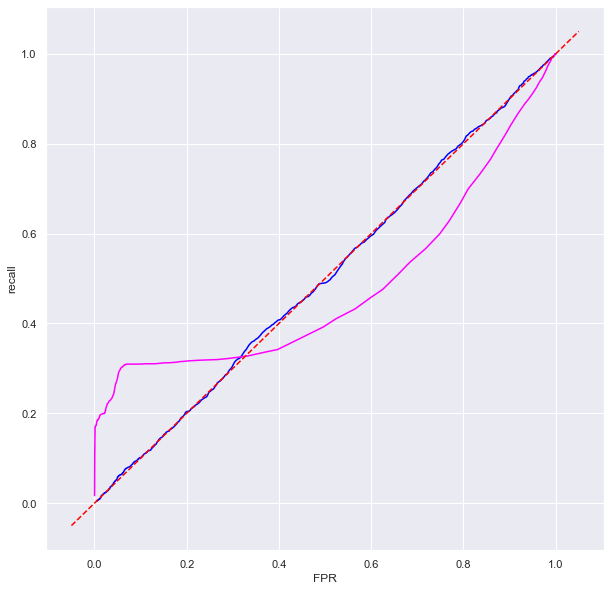

In [27]:
# Plotting OOS ROC curve
FPR_vec_oos = performance_metrics_oos['FPR']
recall_vec_oos = performance_metrics_oos['recall']

sns.lineplot(x=FPR_vec_oos,
             y=recall_vec_oos,
             color = "blue")

# Plotting OOS reduced ROC curve
FPR_vec_oos_reduced = performance_metrics_oos_reduced['FPR']
recall_vec_oos_reduced = performance_metrics_oos_reduced['recall']

sns.lineplot(x=FPR_vec_oos_reduced,
             y=recall_vec_oos_reduced,
             color = "magenta")

abline(1, 0)

## Choosing a Decision Threshold Based on Asymmetric Costs and Rewards

The ROC and DET curves gave you a glimpse into all the possible classification models derived from a probability estimation model. Each point on that curve is a separate $g(x)$ with its own performance metrics. How do you pick one?

Let's create rewards and costs. Imagine we are trying to predict income because we want to sell people an expensive item e.g. a car. We want to advertise our cars via a nice packet in the mail. The packet costs 5 dollars. If we send a packet to someone who really does make over 50 thousand a year then we are expected to make \$1000. So we have rewards and costs below:

In [28]:
r_tp = 1000     # reward for true positive
c_fp = -5       # cost of false positive
c_fn = -500     # cost of false negative
r_tn = 0        # reward for true negative

Let's return to the linear logistic model with all features. Let's calculate the overall oos average reward per observation (per person) for each possible $p_{th}$:

In [29]:
n_test = len(X_test)

performance_metrics_oos['avg_cost'] = (r_tp * performance_metrics_oos['TP'] +
  c_fp * performance_metrics_oos['FP'] +
  c_fn * performance_metrics_oos['FN'] +
  r_tn * performance_metrics_oos['TN']) / n_test
    
performance_metrics_oos

,p_th,TN,FP,FN,TP,miscl_err,precision,recall,FDR,FPR,FOR,miss_rate,avg_cost
0,0.001,0.0,5601.0,0.0,1940.0,0.742740,0.257260,1.000000,0.742740,1.000000,0.000000,0.000000,126.756497
1,0.002,0.0,5601.0,0.0,1940.0,0.742740,0.257260,1.000000,0.742740,1.000000,0.000000,0.000000,126.756497
2,0.003,0.0,5601.0,0.0,1940.0,0.742740,0.257260,1.000000,0.742740,1.000000,0.000000,0.000000,126.756497
3,0.004,0.0,5601.0,0.0,1940.0,0.742740,0.257260,1.000000,0.742740,1.000000,0.000000,0.000000,126.756497
4,0.005,0.0,5601.0,0.0,1940.0,0.742740,0.257260,1.000000,0.742740,1.000000,0.000000,0.000000,126.756497
...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,0.995,5568.0,33.0,1929.0,11.0,0.260178,0.250000,0.005670,0.750000,0.005892,0.257303,0.994330,-63.223614
995,0.996,5569.0,32.0,1931.0,9.0,0.260310,0.219512,0.004639,0.780488,0.005713,0.257467,0.995361,-63.422169
996,0.997,5571.0,30.0,1931.0,9.0,0.260045,0.230769,0.004639,0.769231,0.005356,0.257398,0.995361,-63.421506
997,0.998,5573.0,28.0,1931.0,9.0,0.259780,0.243243,0.004639,0.756757,0.004999,0.257329,0.995361,-63.420843


<AxesSubplot:xlabel='p_th', ylabel='avg_cost'>

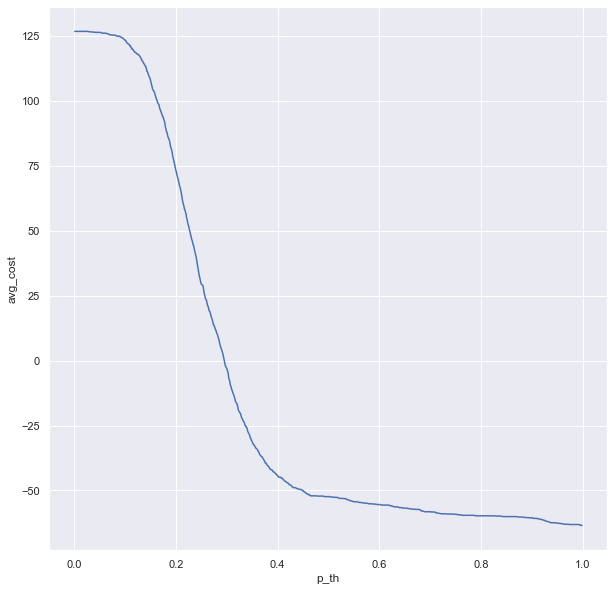

In [30]:
sns.lineplot(data = performance_metrics_oos,
             x = 'p_th',
             y = 'avg_cost')

Obviously, the best decision is $p_{th} \approx 0$ which means you classifiy almost everything as a positive. This makes sense because the mailing is so cheap. What are the performance characteristics of the optimal model?

In [31]:
# get index of row with max avg_cost
i_star = performance_metrics_oos[['avg_cost']].idxmax()
print(i_star)

# get row at i_star
performance_metrics_oos.iloc[i_star]

avg_cost    26
dtype: int64


,p_th,TN,FP,FN,TP,miscl_err,precision,recall,FDR,FPR,FOR,miss_rate,avg_cost
26,0.027,4.0,5597.0,0.0,1940.0,0.742209,0.257397,1.0,0.742603,0.999286,0.0,0.0,126.757823


Let's observe what happens when the cost of advertising is greater:

<AxesSubplot:xlabel='p_th', ylabel='avg_cost'>

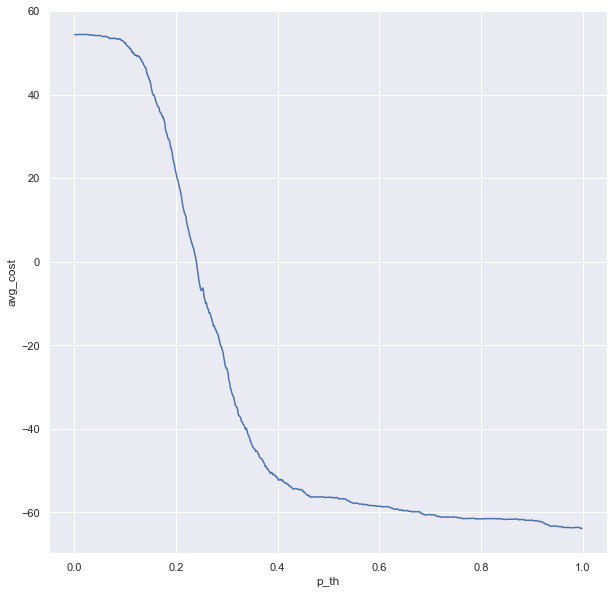

In [32]:
r_tp = 1000     # reward for true positive
c_fp = -200       # cost of false positive
c_fn = -500     # cost of false negative
r_tn = 0        # reward for true negative

n_test = len(X_test)

performance_metrics_oos['avg_cost'] = (r_tp * performance_metrics_oos['TP'] +
  c_fp * performance_metrics_oos['FP'] +
  c_fn * performance_metrics_oos['FN'] +
  r_tn * performance_metrics_oos['TN']) / n_test
    
performance_metrics_oos

# plotting it
sns.lineplot(data = performance_metrics_oos,
             x = 'p_th',
             y = 'avg_cost')

What are the performance characteristics of the optimal model?

In [33]:
# get index of row with max avg_cost
i_star = performance_metrics_oos[['avg_cost']].idxmax()
print(i_star)

# get row at i_star
performance_metrics_oos.iloc[i_star]

avg_cost    26
dtype: int64


,p_th,TN,FP,FN,TP,miscl_err,precision,recall,FDR,FPR,FOR,miss_rate,avg_cost
26,0.027,4.0,5597.0,0.0,1940.0,0.742209,0.257397,1.0,0.742603,0.999286,0.0,0.0,54.402015


If $g_{pr}$ is closer to $f_{pr}$, what happens? 

All the threshold-derived classification models get better and you are guaranteed to make more money since you have a better discriminating eye.

There is also a way to make asymmetric models with trees. We will do this later to give you time for the general concept to sink in.

Below is another example of some of the concepts in this demo. Data is generated, and we plot the ROC and DET curves. The blue line shows the performance for a Linear SVM classifier and the orange for a Random Forest classifier.

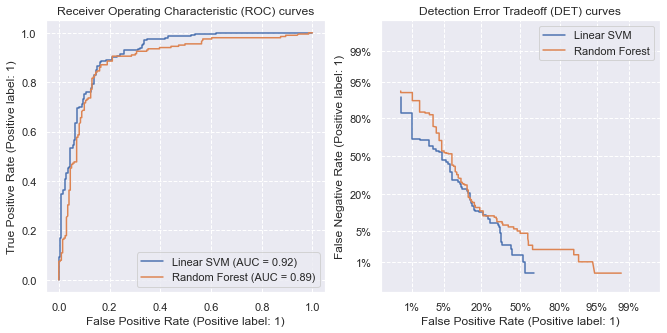

In [34]:
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

N_SAMPLES = 1000

classifiers = {
    "Linear SVM": make_pipeline(StandardScaler(), LinearSVC(C=0.025)),
    "Random Forest": RandomForestClassifier(
        max_depth=5, n_estimators=10, max_features=1
    ),
    
}

X, y = make_classification(
    n_samples=N_SAMPLES,
    n_features=4,
    n_redundant=0,
    n_informative=2,
    random_state=1,
    n_clusters_per_class=2,
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

# prepare plots
fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)

    RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax_roc, name=name)
    DetCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax_det, name=name)

ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
ax_det.set_title("Detection Error Tradeoff (DET) curves")

ax_roc.grid(linestyle="--")
ax_det.grid(linestyle="--")

plt.legend()
plt.show()